# Assignment 3

## Data Mining questions

### 1- What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?
- **Character n-gram** is a contiguous series of n characters from a given sample of text or speech, whereas **word n-grams** is is a contiguous series of n words from a given sample of text or speech, and the one who will suffer from the **out-of-vocabulary** issue is **word n-gram**
<hr>

### 2- What is the difference between stop word removal and stemming? Are these techniques language-dependent?
- Both, Are the most important preprocessing techniques for text, but the main difference is that the *stop word removal* totally remove some predefined words that it knows from the sentence and have a list of these words, in other hand, *stemming* is about to reduce the word and return it to its root, like removing suffix and prefixes not removing the whole word, ex (playing -> play), etc, both are language dependant stop words in English not like in German and vice versa also the grammars in English not like in the German language. 

<hr>

### 3-  Is tokenization techniques language dependent? Why?
- No, It divides a chunk of text into distinct words based on a specific delimiter. Different word-level tokens are created depending on the delimiters, not the language.

<hr>

### 4- What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?

- **count vectorizer** used to convert a text into a vector-based on the frequency (count) of each word that appears throughout the text, whereas **tf-idf vectorizer** it divides into two parts **TF** which is refer to term frequency where we count how many time that the word appears in the text and then dividing it by the total numbers of words in the whole text, where **IDF** is about taking the logarithm to the previous result to decrease the weight of a common word in the sentence or document, it wouldn't be feasiable and it would be **np-complete** problem,but you can select them by using some of search method techniques like (Grid search, random search).

## Problem formulation:

our problem here is about building a model to classify and detect which real news and fake news from just its titles, our inputs here are news titles (60001) observations for a training dataset and the output is (60001) label.

#### **Note:- you'll find the dataset at https://www.kaggle.com/competitions/cisc-873-dm-f22-a3**

### Data mining function:
- text preprocessing -> tokenization and vectorization each text -> building and training the model -> classification and prediction.

### The challenges:

- We have a quite big data set so maybe will take some time to preprocess it and train it.

- Our input here is dirty text, each observation here has a lot of punctuation and non-English letters and misspellings, and grammatical mistakes because each title here is typed by humans, so we need to choose a proper text cleaning technique by trying each one them and choose the one who give us best results.

- Even if we cleaned our input here, it's still string data and machine learning models can't deal with string data so we need to convert them into numeric data by technique called vectorization.

### The impact:
- Building this model will solve many social problems and prevent the spread of rumors on social media quickly.

### The ideal solution:
- a pipeline has **tf-idf vectorizer** and **logistic regression model** and searches for the best hyperparameter combination using random search technique. **(roc_auc score) 0.87006, third place**.


## Experimental protocol:

- Read training data.
- Preprocessing:
    * cleaning input data for both training set and test set using some regular expressions patterns and stemming or lemmatizing each text.
- Data exploration
- Data vectorization: There are two famous vectorization techniques **count vectorizer** and **tf-idf vectorizer** we will try each one of them and choose the one who will give us best results.
- Building our piplines (has the vectorizer and machine learning model)
- Build the search speace and search for the best hyperparameters combinations but trying many fits.
- Test our model
- Choose the best one

REF: https://onq.queensu.ca/d2l/le/content/626484/viewContent/3870297/View

Day 7 > lab 5-6 NLP > 873_nlp.ipynb

### Import all required packages

In [1]:
import re
import pickle
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### read training dataset and test dataset

In [3]:
data = pd.read_csv('xy_train.csv', sep=",", na_values=[""])
data = data.drop(data[data.label == 2].index)
data.label = data.label.astype('int8')

test = pd.read_csv('x_test.csv',index_col='id')
id = test.index
print(test.shape)

(59151, 1)


### Define two methods for text cleaning

First method will clean text and will **lemmtize** each text if <code>for_embedding</code> parameter was false.

Second method will clean text and will **stem** each text if <code>for_embedding</code> parameter was false.

In [4]:
stop_words = set(stopwords.words("english"))
#nltk.download('wordnet')
#nltk.download('punkt')
print(stop_words)

def RegEx_clean(text, for_embedding):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace

    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) #match one or more white sepace
    RE_TAGS = re.compile(r"<.*?>") #match <any num of words>
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž0-9]+", re.IGNORECASE) #match any English word
    RE_SINGLECHAR = re.compile(r"\b^[^A-Za-zÀ-ž0-9]+\b", re.IGNORECASE) #match any word with word boundary.
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE) #match any English word and any punctuation
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE) #match any word and any punctuation with word boundary.

    text = re.sub(RE_TAGS, " ", text) #remove one or more white sepace
    text = re.sub(RE_ASCII, " ", text) #remove <any num of words>
    text = re.sub(RE_SINGLECHAR, " ", text) #remove any English word
    text = re.sub(RE_WSPACE, " ", text) #remove any word with word boundary.
    word_tokens = word_tokenize(text)
    
    return word_tokens

def lemmatize_clean_text(text ,for_embedding=False):

    """ steps:
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and lemmatize
    """

    lemmatizer = WordNetLemmatizer()

    word_tokens = RegEx_clean(text, for_embedding)

    if for_embedding:
        # no stemming or lemmatization, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_tokens_lower = [word.lower() for word in word_tokens]
        words_filtered = [lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words]

    clean_text = " ".join(words_filtered)
    return clean_text



def stemming_clean_text(text ,for_embedding=False):
    """ steps:
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemming
    """

    stemmer = SnowballStemmer("english")

    word_tokens = RegEx_clean(text,for_embedding)

    if for_embedding:
        # no stemming or lemmatization, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_tokens_lower = [word.lower() for word in word_tokens]
        words_filtered = [stemmer.stem(word) for word in words_tokens_lower if word not in stop_words]

    clean_text = " ".join(words_filtered)
    return clean_text


{"shan't", 'of', 'doing', 'between', 'both', 'shouldn', 'under', 'o', 'me', 'over', 'what', 'own', 'or', 're', 'be', 'your', 'with', 'were', 'once', 'an', 'i', 'wouldn', "hadn't", "mustn't", "you'll", 'on', 'aren', "hasn't", 'into', 'no', 'should', "wouldn't", 'against', 'will', 'out', 'now', 'needn', 'further', 'before', 'so', 'too', 'who', 'you', "won't", 'from', 'doesn', 'mightn', 'weren', 'only', 'if', 'ain', 'just', 'do', 'its', 'up', 'all', 'while', 'them', "don't", 'having', "wasn't", 'there', 'and', 'hadn', 'my', 'herself', 'myself', 'this', "shouldn't", 'but', 'have', 'then', 've', 'our', "she's", 'himself', 'did', 'such', 'themselves', 's', 'each', 'm', "you're", "weren't", 'very', 'y', 'again', 'after', 'wasn', 'same', 'hers', 'll', 'his', 'how', 'not', 'yourselves', 'where', 'they', 'theirs', 'that', 'why', 'some', 'haven', 'their', 'other', 'the', "isn't", 'being', 'during', 'ma', 'been', "mightn't", 'does', 'can', 'above', 'has', "that'll", 'these', 'had', 'in', 'yourself

### Start preprocessing text feature in two ways.

1- clean text with lemmatizing each word in the text (lemmatizing will remove any word ending with take in consideration the meaning of the word).<br>
2- clean text with stemming each word in the text  (stemming will remove any word ending without take in consideration the meaning of the word).<br>

In [5]:
data["text"] = data.loc[data["text"].str.len() > 20, "text"]
data_lemmatized = data["text"].map(lambda x: lemmatize_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## clean and lemmatiz training set
data_stemmed = data["text"].map(lambda x: stemming_clean_text(x, for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and stemming training set
test_lemmatized = test["text"].map(lambda x: lemmatize_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set
test_stemmed = test["text"].map(lambda x: stemming_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set

### Data Exploration

see the difference between each preprocessing technique.

look at the first sentence **"group friend began volunteer homeless shelter neighbor protested seeing another person also need..."**

see the words **'protested'** and **'another'** in this sentence after lemmatizing.

In [6]:
# first sentence:  group friend began volunteer homeless shelter neighbor protested seeing another person also need...
data_lemmatized.head(10)

0    group friend began volunteer homeless shelter neighbor protested seeing another person also need...
1    british prime minister theresa may nerve attack former russian spy government concluded highly l...
2    1961 goodyear released kit allows ps2s brought heel http youtube com watch v alxulk0t8cg 0 72 0 ...
3    happy birthday bob barker price right host like remembered man said ave pet spayed neutered 0 92...
4    obama nation innocent cop unarmed young black men dying magic johnson 1 0 0 2 1 jimbobshawobodob...
5    1920 hitler forbidden address public meeting much germany major blow nazi poster cartoonist phil...
6    nerd win scrabble word never heard braconid meaning ny numerous wasp family braconidae larva whi...
7    95 8 female newscaster hair style standard result longstanding requirement female reporter job f...
8    donald trump say inappropriate tape come continue talk bill hillary clinton inappropriate thing ...
9    5 crazy fact lamborghini outrageous electric super

look at the first sentence **"group friend began volunteer homeless shelter neighbor protested seeing another person also need..."**

see the words **'protested'** and **'another'** in this sentence after stemming them.

In [7]:
data_stemmed.head(100)

0      group friend began volunt homeless shelter neighbor protest see anoth person also need natur lik...
1      british prime minist theresa may nerv attack former russian spi govern conclud high like russia ...
2      1961 goodyear releas kit allow ps2s brought heel https youtub com watch v alxulk0t8cg 0 72 0 2 3...
3      happi birthday bob barker price right host like rememb man said ave pet spay neuter 0 92 0 2 5 f...
4      obama nation innoc cop unarm young black men die magic johnson 1 0 0 2 1 jimbobshawobodob olymp ...
5      1920 hitler forbidden address public meet much germani major blow nazi poster cartoonist philipp...
6      nerd win scrabbl word never heard braconid mean ny numer wasp famili braconida larva whichar par...
7      95 8 femal newscast hair style standard result longstand requir femal report job fulfil larger a...
8      donald trump say inappropri tape come continu talk bill hillari clinton inappropri thing 0 94 0 ...
9      5 crazi fact lamborghini outra

In [8]:
# Word Frequency of most common words in data_lemmatized
word_freq_lemmatized = pd.Series(" ".join(data_lemmatized).split()).value_counts()
word_freq_lemmatized[1:40]

year         4121
one          3285
new          2998
like         2949
man          2705
trump        2577
u            2513
colorized    2430
people       2315
first        2247
old          2222
look         2214
say          2147
get          2072
time         2011
poster       1999
2            1987
found        1959
day          1934
woman        1892
war          1858
life         1768
make         1727
1            1697
world        1570
american     1498
psbattle     1468
state        1387
post         1384
two          1364
school       1339
back         1325
photo        1324
made         1314
right        1301
r            1266
circa        1249
child        1216
know         1201
dtype: int64

In [9]:
# Word Frequency of most common words in data_stemmed

word_freq_stemmed = pd.Series(" ".join(data_stemmed).split()).value_counts()
word_freq_stemmed[1:40]

year        4125
one         3285
like        3128
new         2998
look        2847
color       2737
man         2728
get         2602
trump       2578
say         2347
peopl       2316
use         2307
first       2248
make        2227
old         2226
time        2027
poster      2000
found       1999
2           1986
day         1934
war         1858
1           1697
post        1648
world       1570
work        1531
show        1513
american    1504
us          1504
take        1491
life        1481
psbattl     1470
help        1442
go          1418
state       1409
back        1369
two         1364
school      1345
see         1329
photo       1324
dtype: int64

In [10]:
word_freq_stemmed[-10:].reset_index(name="freq")

,index,freq
0,darli,1
1,cvtwtq,1
2,cornerston,1
3,soot,1
4,codina,1
5,sebasti,1
6,nearsight,1
7,poaq69oe7ti31,1
8,1741x2604,1
9,110k,1


<AxesSubplot:title={'center':'Balanced dataset'}>

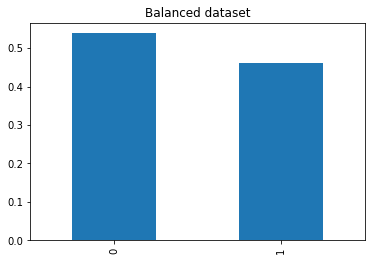

In [11]:
# 0 to 1 ratio
data["label"].value_counts(normalize=True).plot(kind='bar',title='Balanced dataset')

### Split our data from test purposes.

In [12]:
#split data_lemmatized feature

# split the original training set to a train and a validation set becuase we will use them in search method

X_train_1 , X_val_1 , Y_train_1, Y_val_1 = train_test_split(data_lemmatized,data['label'],stratify=data['label'], random_state=42, test_size=0.25, shuffle=True)


split_index_lemmatized = [-1 if x in X_train_1.index else 0 for x in data_lemmatized.index]

print(X_train_1.shape)
print(X_val_1.shape)

(44826,)
(14942,)


In [13]:
#split data_stemmed feature

#Split the original training set to a train and a validation set becuase we will use them in search method

X_train_2, X_val_2 ,Y_train_2, Y_val_2 = train_test_split(data_stemmed,data['label'],stratify=data['label'], random_state=42, test_size=0.25, shuffle=True)


split_index_stemmed = [-1 if x in X_train_2.index else 0 for x in data_stemmed.index]


print(X_train_2.shape)
print(X_val_2.shape)

(44826,)
(14942,)


### Start building our models and test each of them on each feature.

### Trial-1: Define a tunable pipeline with *TfidfVectorizer* and *logistic regression* model on stemmed data.

we will train a pipeline on the whole dataset with pre-defined validation set.

First things first: I convert each text the input column to numerical values using TfidfVectorizer then I tried to train them using logistic regression classifier.

In [14]:
# feature creation and modelling in a single function
pipe_lg = Pipeline([("tfidf", TfidfVectorizer()), ("lg", LogisticRegression(max_iter=10000,random_state=42,n_jobs=-1))])

ps_1 = PredefinedSplit(split_index_stemmed)


# define parameter space to test
params = {
    "tfidf__ngram_range": [(1, 2), (1, 3), (1,4), (1,5)],
    "tfidf__max_df": np.arange(0.2, 1.0),
    "tfidf__min_df": np.arange(5, 100),
    "tfidf__analyzer": ['word','char','char_wb'],
    "tfidf__strip_accents":[None,'ascii','unicode'],
    'tfidf__smooth_idf':[False,True],
    "tfidf__sublinear_tf":[True,False]
}

# here we still use data_lemmatized; but the random search model will use our predefined split internally to determine which sample belongs to the validation set

pipe_lg_clf = RandomizedSearchCV(pipe_lg, params, n_jobs=-1,cv=ps_1, scoring="roc_auc", n_iter=50)
pipe_lg_clf.fit(data_stemmed, data['label'])

pickle.dump(pipe_lg_clf, open("./clf_pipe.pck", "wb"))

In [15]:
print('best score {}'.format(pipe_lg_clf.best_score_))
print('best score {}'.format(pipe_lg_clf.best_params_))

best score 0.8842549027632801
best score {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 9, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'word'}


Take the best hyperparameter combination for <code>TfidfVectorizer()</code> and use them with the model to search for best hyperparameters combination for the model.

Using this best hyperparameters for <code>TfidfVectorizer()</code>, we can search for optimal hyperparameters for the `logistic regression` classifier becuase thet will improve the classification results:

In [16]:
pipe_lg = Pipeline([("tfidf", TfidfVectorizer()), ("lg", LogisticRegression(max_iter=10000,random_state=42,n_jobs=-1))])

# define parameter space to test # runtime 2 min
params = {
    'tfidf__sublinear_tf':[True], #True best
    'tfidf__strip_accents':[None],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 5)], #(1,2)
    'tfidf__analyzer':['char'],
    'tfidf__min_df': [11], 
    'tfidf__max_df': [0.2],
    'lg__class_weight':['balanced',None],
    "lg__solver" : ['sag','newton-cg', 'lbfgs','liblinear','saga'],
    'lg__C': [1.0,0.1,0.001,0.0001,0.005,1.5,2.0,3.5],
    'lg__fit_intercept':[False, True],

}
#    
#   
# it is quite slow so we do 4 for now
pipe_lg_clf = RandomizedSearchCV(pipe_lg, params, n_jobs=-1,cv=ps_1, scoring="roc_auc", n_iter=50)
pipe_lg_clf.fit(data_stemmed, data['label'])

pickle.dump(pipe_lg_clf, open("./clf_pipe.pck", "wb"))

In [17]:
print('best score {}'.format(pipe_lg_clf.best_score_))
print('best score {}'.format(pipe_lg_clf.best_params_))

# best score {'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': True, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 12, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char', 'lg__solver': 'sag', 'lg__fit_intercept': False, 'lg__class_weight': None, 'lg__C': 3.5} 0.881381704490526
# best score {'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'ascii', 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 5, 'tfidf__max_df': 0.3, 'tfidf__analyzer': 'word', 'lg__solver': 'sag', 'lg__fit_intercept': False, 'lg__C': 2.0} 0.8822453312417121
# best score {'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'ascii', 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 5, 'tfidf__max_df': 0.3, 'tfidf__analyzer': 'word', 'lg__solver': 'lbfgs', 'lg__fit_intercept': False, 'lg__C': 2.0} 0.8823252722847258
# best score {'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'ascii', 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__analyzer': 'word', 'lg__solver': 'sag', 'lg__fit_intercept': False, 'lg__C': 3.5} 0.8827944487105306
# best score {'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'ascii', 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__analyzer': 'word', 'lg__penalty': 'l2', 'lg__fit_intercept': False, 'lg__C': 3.5} 0.8827951346447609
# best score {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 2), 'tfidf__analyzer': 'word', 'lg__solver': 'liblinear', 'lg__fit_intercept': False, 'lg__class_weight': 'balanced', 'lg__C': 3.5} 0.8834023255296484
# best score {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__analyzer': 'word', 'lg__solver': 'liblinear', 'lg__fit_intercept': False, 'lg__class_weight': 'balanced', 'lg__C': 3.5} 0.8837091356960659

best score 0.8903333162307389
best score {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': None, 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 11, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char', 'lg__solver': 'newton-cg', 'lg__fit_intercept': True, 'lg__class_weight': 'balanced', 'lg__C': 3.5}


Best hyperparameters combinations and roc_auc score for <code>TfidfVectorizer()</code> with logistic regression classifier

In [18]:
best_params_lg = pipe_lg_clf.best_params_
print(best_params_lg)

{'tfidf__sublinear_tf': True, 'tfidf__strip_accents': None, 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 11, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char', 'lg__solver': 'newton-cg', 'lg__fit_intercept': True, 'lg__class_weight': 'balanced', 'lg__C': 3.5}


In [19]:
pipe_lg.set_params(**best_params_lg).fit(data_stemmed, data['label'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.2, min_df=11,
                                 ngram_range=(1, 5), smooth_idf=False,
                                 sublinear_tf=True)),
                ('lg',
                 LogisticRegression(C=3.5, class_weight='balanced',
                                    max_iter=10000, n_jobs=-1, random_state=42,
                                    solver='newton-cg'))])

In [20]:
#create submission file
submission = pd.DataFrame()

submission['id'] = id
print(len(test['text']))
submission['label'] = pipe_lg.predict_proba(test['text'])[:,1]
submission.to_csv('sample_submission_walkthrough_lg.csv', index=False)

59151


### Intuitions about first trial result:

Here logisitc regression was able to get the best score on kaggle (roc_auc = 0.87006), the model didn't overfit after hyperparameter tuning with random search (I can improve the score metric if I use grid search to search for best hyperparameter combination), and maybe it would get better score if I tried on lemmatized data not stemmed one.

### Trial-2: Define a tunable pipeline with *TfidfVectorizer* and *Xgboosting* model on lemmatized data.

First things first: I convert each text the input column to numerical values using TfidfVectorizer then I tried to train them using Xgboosting classifier and evaluate the model results using predefined validation dataset.

In [43]:
# feature creation and modelling in a single function
pipe_xgb = Pipeline([("tfidf", TfidfVectorizer()), ("xgb", XGBClassifier(random_state=42,n_jobs=-1,eval_metric='rmse',use_label_encoder=False))])

ps_2 = PredefinedSplit(split_index_lemmatized)


# define parameter space to test
params = {
    "tfidf__ngram_range": [(1, 2), (1, 3), (1,4), (1,5)],
    "tfidf__max_df": np.arange(0.2, 1.0),
    "tfidf__min_df": np.arange(5, 100),
    "tfidf__strip_accents":[None,'ascii','unicode'],
    'tfidf__analyzer':['word','char','char_wb'],
    'tfidf__smooth_idf':[False,True],
    "tfidf__sublinear_tf":[True,False]
}

# here we still use data_lemmatized; but the random search model will use our predefined split internally to determine which sample belongs to the validation set

pipe_xgb_clf = RandomizedSearchCV(pipe_xgb, params, n_jobs=-1,cv=ps_2, scoring="roc_auc", n_iter=45)
pipe_xgb_clf.fit(data_lemmatized, data['label'])

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric='rmse',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,

Best hyperparameters combinations and roc_auc score for <code>TfidfVectorizer()</code> with XG boosting classifier.

In [44]:
print('best score {}'.format(pipe_xgb_clf.best_score_))
print('best score {}'.format(pipe_xgb_clf.best_params_))

best score 0.873591516190417
best score {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': 'ascii', 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 4), 'tfidf__min_df': 5, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char'}


Using this best hyperparameters for <code>TfidfVectorizer()</code>, we can search for optimal hyperparameters for the `XGB` classifier:

In [45]:
pipe_xgb = Pipeline([("tfidf", TfidfVectorizer()), ("xgb", XGBClassifier(random_state=42,n_jobs=-1, eval_metric='rmse',use_label_encoder=False))])

# define parameter space to test # runtime 17 min
params = {
    'tfidf__sublinear_tf':[True], #True best
    'tfidf__strip_accents':[None],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 5)], #(1,2)
    'tfidf__min_df': [11], 
    'tfidf__max_df': [0.2],
    'tfidf__analyzer':['word','char','char_wb'],
    'xgb__booster':['gbtree','gblinear', 'dart'],
    'xgb__learning_rate':[1.0, 0.1,0.01,0.0001, 1.5],

}
   
pipe_xgb_clf = RandomizedSearchCV(pipe_xgb, params, n_jobs=-1,cv=ps_2, scoring="roc_auc", n_iter=45)
pipe_xgb_clf.fit(data_lemmatized, data['label'])

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric='rmse',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,

In [46]:
print('best score {}'.format(pipe_xgb_clf.best_score_))
print('best score {}'.format(pipe_xgb_clf.best_params_))

best score 0.8805476225528399
best score {'xgb__learning_rate': 0.01, 'xgb__booster': 'gblinear', 'tfidf__sublinear_tf': True, 'tfidf__strip_accents': None, 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 11, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'word'}


In [47]:
best_params_xgb = pipe_xgb_clf.best_params_
print(best_params_xgb)

{'xgb__learning_rate': 0.01, 'xgb__booster': 'gblinear', 'tfidf__sublinear_tf': True, 'tfidf__strip_accents': None, 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 11, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'word'}


In [48]:
pipe_xgb.set_params(**best_params_xgb).fit(data_lemmatized, data['label'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.2, min_df=11, ngram_range=(1, 5),
                                 smooth_idf=False, sublinear_tf=True)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gblinear',
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               eval_metric='rmse', gamma=None, gpu_id=-1,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, reg_alpha=0,
               

In [49]:
#create submission file
submission = pd.DataFrame()
submission['id'] = id
print(len(test['text']))
submission['label'] = pipe_lg.predict_proba(test['text'])[:,1]
submission.to_csv('sample_submission_walkthrough_xgb.csv', index=False)

59151


### Intuitions about second trial result:

Here xgboosting classifier score wasn't like the first trail **(roc_auc score = 0.86437)** although I passed a better data to it (lemmatized data), maybe I should try using grid search to search for the best hyperparameters combinations but that would take a lot of time to search for these hyperparamters combinations 

### Trial 3: **TfidfVectorizer()** (*character-level*) with random forest classifier on lemmatized data.

Here I made tf_idf and random forest classifier hyperparameters are selected by me to see if that imporve the score, and I use random forest classifier because it's much more better than xgboosting classifier in terms of computation speed.

In [28]:
#Compute unique word vector with frequencies exclude very uncommon (<10 obsv.) and common (>=20%) words use pairs of two words (ngram)

tf_idf_vectorizer = TfidfVectorizer(
    analyzer="char", max_df=0.2, min_df=10, ngram_range=(1, 3), norm="l2"
)
tf_idf_vectorizer.fit(data_lemmatized)

TfidfVectorizer(analyzer='char', max_df=0.2, min_df=10, ngram_range=(1, 3))

In [29]:
# Vector representation of vocabulary
word_vector = pd.Series(tf_idf_vectorizer.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n {word_vector}")

Unique word (ngram) vector extract:

 zul    9457
sw     7998
pag    7047
mri    6173
211    1053
dtype: int64


In [30]:
# transform each sentence to numeric vector with tf-idf value as elements
data_lemmatized_vec = tf_idf_vectorizer.transform(data_lemmatized)
X_test_vec = tf_idf_vectorizer.transform(test_lemmatized)
data_lemmatized_vec.get_shape()

(59768, 9475)

### Start training random forest classifier

In [31]:
model_rf = RandomForestClassifier(n_estimators=150,max_depth=7,max_leaf_nodes=5)
model_rf.fit(data_lemmatized_vec,data['label'])

RandomForestClassifier(max_depth=7, max_leaf_nodes=5, n_estimators=150)

In [32]:
#create submission file
submission = pd.DataFrame()
submission['id'] = id
submission['label'] = model_rf.predict_proba(X_test_vec)[:,1]
submission.to_csv('sample_submission_walkthrough_rf.csv', index=False)

### Intuitions about third trial result:

Random forest calssifier results was same as xgboosting results and I think because they are tree algorithms but random forest classifier is much more faster in training if I tried to fine tune the hyperparameters I think I would get higher results.

### Trial 4: **CountVectorizer()** *(word-level)* with Naive bayes classifier *default hyperparameters* on stemmed data.

Here I tried Naive bayes classifier with default hyperparameters but now I changed the vectorizer from tf_idf to countvectorizer to see which will do better for this problem.

In [33]:
#Compute unique word vector with frequencies exclude very uncommon (<10 obsv.) and common (>=30%) words use pairs of two words (ngram)

count_vectorizer = CountVectorizer(
    analyzer="word", max_df=0.3, min_df=10, ngram_range=(1, 3)
)
count_vectorizer.fit(data_stemmed)

CountVectorizer(max_df=0.3, min_df=10, ngram_range=(1, 3))

In [34]:
# Vector representation of vocabulary
word_vector = pd.Series(count_vectorizer.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n {word_vector}")

Unique word (ngram) vector extract:

 peanut           7093
duti             3155
1492               73
firearm          3724
rudi giuliani    8227
dtype: int64


In [35]:
# transform each sentence to numeric vector with count value as elements

data_stemmed_vec = count_vectorizer.transform(data_stemmed)
X_test_vec_2 = count_vectorizer.transform(test_stemmed)
data_stemmed_vec.get_shape()

(59768, 10741)

### Start training multinomial naive bayes classifier

In [36]:
model_NV = MultinomialNB()
model_NV.fit(data_stemmed_vec,data['label'])

MultinomialNB()

In [37]:
#create submission file
submission = pd.DataFrame()

submission['id'] = id
submission['label'] = model_NV.predict_proba(X_test_vec_2)[:,1]
submission.to_csv('sample_submission_walkthrough_nv.csv', index=False)

### Intuitions about fifth trial result:

This trial's score was the worest **(roc_auc = 0.71165)**, and to check if this was vectorizer fault or classifier fault I tried another trial but not in this file with tf_id vectorizer and the same classifier and I noticed that the result increased and was close to the other results, so in kind of this problem count_vectorizer is not a good choice.

### Last trail: **TfidfVectorizer()** (*word-level*)  with XG boosting classifier on lemmatized data.

Based on my friends advice, they said the XG boosting classifier result was good for them, so I tried to change the analyzer of tf_idf vectorizer here from 'character' to 'word' without any hyperparameter tuning.

In [38]:
tf_idf_vectorizer_xgb = TfidfVectorizer(
    analyzer="word", max_df=0.4, min_df=10, ngram_range=(1, 2)
)
tf_idf_vectorizer_xgb.fit(data_lemmatized)

TfidfVectorizer(max_df=0.4, min_df=10, ngram_range=(1, 2))

In [39]:
# Vector representation of vocabulary
word_vector = pd.Series(tf_idf_vectorizer_xgb.vocabulary_).sample(5, random_state=1)
print(f"Unique word (ngram) vector extract:\n\n {word_vector}")

Unique word (ngram) vector extract:

 operation barbarossa     7373
good time                4653
franchise                4333
wwii propaganda         11512
unarmed                 10841
dtype: int64


In [40]:
# transform each sentence to numeric vector with tf-idf value as elements

data_stemmed_vec_xgb = tf_idf_vectorizer_xgb.transform(data_stemmed)
X_test_vec_xgb = tf_idf_vectorizer_xgb.transform(test_stemmed)
data_stemmed_vec_xgb.get_shape()

(59768, 11608)

### Start training xgb classifier.

In [41]:
model_xgb = XGBClassifier(eval_metric='rmse',max_depth=5,n_estimators=200,use_label_encoder=False)
model_xgb.fit(data_stemmed_vec_xgb,data['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [50]:
#create submission file
submission = pd.DataFrame()

submission['id'] = id
submission['label'] = model_xgb.predict_proba(X_test_vec_xgb)[:,1]
submission.to_csv('sample_submission_walkthrough_xgb2.csv', index=False)

### Intuitions about last trial result:

xgboosting calssifier results was better than second trial although I changed one parameter in the vectorizer which was analyzer **(roc_auc = 0.86350)**, by that I noticed this problem the best vectorizer to vectorize the data was tf_id vectorizer and the best analyzer was word, count_vectorizer in this problem wasn't good at all.